Deep Learning Text Classification Customer Complaint Dataset 
Author:Logeshwar BS

Class Distribution After Balancing:
 category
0    744
1    744
3    744
2    744
Name: count, dtype: int64
Epoch 1/30
75/75 [==============================] - 38s 437ms/step - loss: 1.3876 - accuracy: 0.2471 - val_loss: 1.3848 - val_accuracy: 0.2651
Epoch 2/30
75/75 [==============================] - 35s 471ms/step - loss: 1.3864 - accuracy: 0.2513 - val_loss: 1.3832 - val_accuracy: 0.2987
Epoch 3/30
75/75 [==============================] - 35s 471ms/step - loss: 1.3854 - accuracy: 0.2529 - val_loss: 1.3765 - val_accuracy: 0.2987
Epoch 4/30
75/75 [==============================] - 36s 480ms/step - loss: 1.3842 - accuracy: 0.2496 - val_loss: 1.3756 - val_accuracy: 0.3020
Epoch 5/30
75/75 [==============================] - 36s 483ms/step - loss: 1.3662 - accuracy: 0.2697 - val_loss: 1.3779 - val_accuracy: 0.2701
Epoch 6/30
75/75 [==============================] - 34s 458ms/step - loss: 1.3596 - accuracy: 0.2798 - val_loss: 1.3833 - val_accuracy: 0.2466
Epoch 7/30
19/19 [================

c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_c

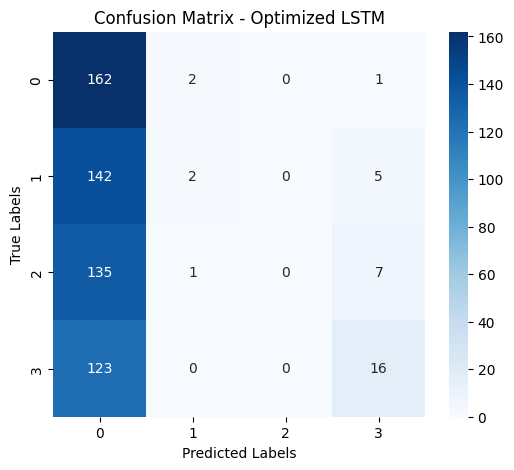

1/1 [==============================] - 0s 55ms/step
Predicted Category: Credit reporting or other personal consumer reports


In [ ]:

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Cell 2: Load the Dataset
file_path = "complaints.csv"  
df = pd.read_csv(file_path, low_memory=False)


selected_categories = [
    "Credit reporting or other personal consumer reports",
    "Debt collection",
    "Consumer Loan",
    "Mortgage"
]
df = df[df["Product"].isin(selected_categories)]

 Randomly Select 100,000 Rows from Filtered Dataset
df = df.sample(n=min(100000, len(df)), random_state=42)


product_mapping = {
    "Credit reporting or other personal consumer reports": 0,
    "Debt collection": 1,
    "Consumer Loan": 2,
    "Mortgage": 3
}
df["category"] = df["Product"].map(product_mapping)

def preprocess_text_simple(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply preprocessing and combine text columns before balancing
df["cleaned_text"] = (
    df["Issue"].apply(preprocess_text_simple) + " " +
    df["Sub-issue"].apply(preprocess_text_simple) + " " +
    df["Consumer complaint narrative"].apply(preprocess_text_simple)
)

# Keep only required columns
df = df[["cleaned_text", "category"]]

# Cell 7: Undersampling - Balance the Categories
min_count = df["category"].value_counts().min()
balanced_df = pd.DataFrame()
for category in df["category"].unique():
    category_subset = df[df["category"] == category]
    category_sampled = resample(category_subset, replace=False, n_samples=min_count, random_state=42)
    balanced_df = pd.concat([balanced_df, category_sampled])


print("Class Distribution After Balancing:\n", balanced_df["category"].value_counts())


X_train, X_test, y_train, y_test = train_test_split(
    balanced_df["cleaned_text"], balanced_df["category"], test_size=0.2, random_state=42
)


vocab_size = 20000  
max_len = 300  

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Convert labels to categorical format
y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

# Cell 10: Define Optimized LSTM Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(4, activation='softmax')
])


optimizer = Adam(learning_rate=0.0005)  # Lower learning rate for stable training
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_cat, 
                    epochs=30, batch_size=32, 
                    validation_data=(X_test_pad, y_test_cat), 
                    callbacks=[early_stop])


lstm_preds = model.predict(X_test_pad).argmax(axis=1)


print("Classification Report:\n", classification_report(y_test, lstm_preds))
conf_matrix = confusion_matrix(y_test, lstm_preds)


plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Optimized LSTM")
plt.show()


def predict_complaint(text):
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=max_len, padding='post')
    prediction = model.predict(text_pad)
    category_idx = prediction.argmax()
    category_mapping_reverse = {v: k for k, v in product_mapping.items()}
    return category_mapping_reverse.get(category_idx, "Unknown Category")

sample_text = """Applying for a mortgage or refinancing an existing mortgage"""
print("Predicted Category:", predict_complaint(sample_text))


In [21]:
from tensorflow.keras.layers import Embedding, Dense, Dropout, Flatten
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score


Deep Neural Network

Epoch 1/30
75/75 [==============================] - 8s 93ms/step - loss: 1.3712 - accuracy: 0.3395 - val_loss: 1.1460 - val_accuracy: 0.7399
Epoch 2/30
75/75 [==============================] - 7s 91ms/step - loss: 0.6442 - accuracy: 0.7920 - val_loss: 0.1675 - val_accuracy: 0.9631
Epoch 3/30
75/75 [==============================] - 7s 91ms/step - loss: 0.1075 - accuracy: 0.9761 - val_loss: 0.1218 - val_accuracy: 0.9614
Epoch 4/30
75/75 [==============================] - 7s 92ms/step - loss: 0.0465 - accuracy: 0.9882 - val_loss: 0.1156 - val_accuracy: 0.9564
Epoch 5/30
75/75 [==============================] - 7s 93ms/step - loss: 0.0269 - accuracy: 0.9954 - val_loss: 0.1275 - val_accuracy: 0.9581
Epoch 6/30
75/75 [==============================] - 7s 95ms/step - loss: 0.0205 - accuracy: 0.9945 - val_loss: 0.1462 - val_accuracy: 0.9564
Epoch 7/30
19/19 [==============================] - 0s 10ms/step
Classification Report:
               precision    recall  f1-score   support

          

c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

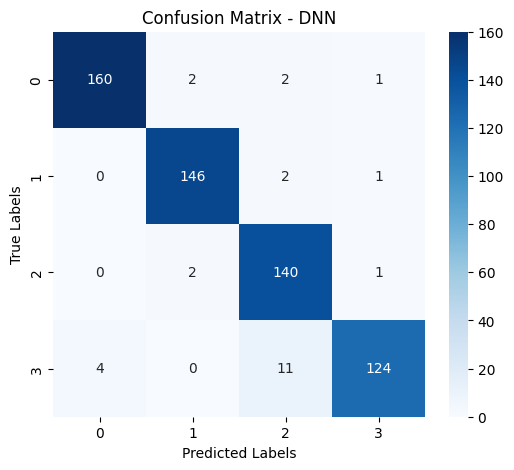

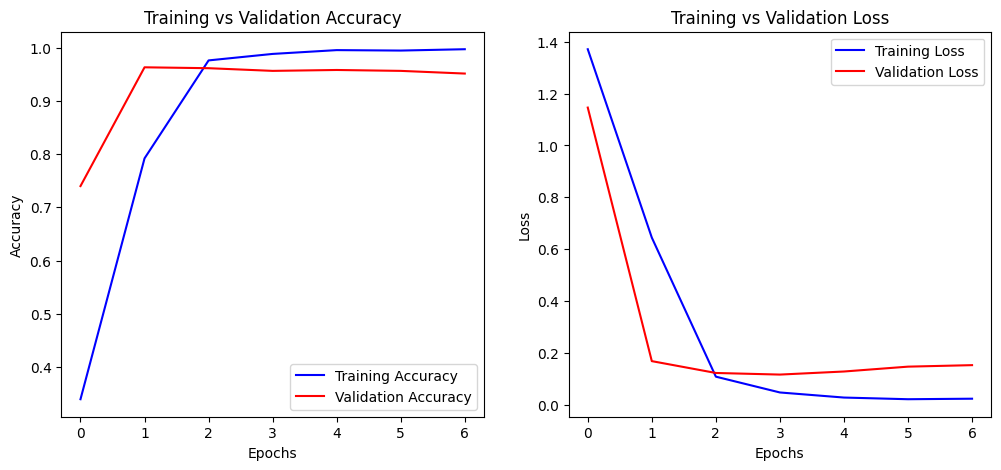

1/1 [==============================] - 0s 34ms/step
Predicted Category: Mortgage


In [ ]:


#  Define Deep Neural Network (DNN) Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(4, activation='softmax')
])


optimizer = Adam(learning_rate=0.0005)  # Lower learning rate for stable training
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_cat, 
                    epochs=30, batch_size=32, 
                    validation_data=(X_test_pad, y_test_cat), 
                    callbacks=[early_stop])


dnn_preds = model.predict(X_test_pad).argmax(axis=1)


print("Classification Report:\n", classification_report(y_test, dnn_preds))
conf_matrix = confusion_matrix(y_test, dnn_preds)


plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - DNN")
plt.show()

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Training Accuracy", color='blue')
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Training Loss", color='blue')
plt.plot(history.history['val_loss'], label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


def predict_complaint(text):
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=max_len, padding='post')
    prediction = model.predict(text_pad)
    category_idx = prediction.argmax()
    category_mapping_reverse = {v: k for k, v in product_mapping.items()}
    return category_mapping_reverse.get(category_idx, "Unknown Category")

# Cell 18: Example Prediction
sample_text = """Applying for a mortgage or refinancing an existing mortgage"""
print("Predicted Category:", predict_complaint(sample_text))


Covolutional Neural Network (CNN)


Epoch 1/30
75/75 [==============================] - 5s 47ms/step - loss: 1.3348 - accuracy: 0.3908 - val_loss: 0.8948 - val_accuracy: 0.6896
Epoch 2/30
75/75 [==============================] - 3s 43ms/step - loss: 0.4516 - accuracy: 0.8361 - val_loss: 0.1669 - val_accuracy: 0.9513
Epoch 3/30
75/75 [==============================] - 3s 43ms/step - loss: 0.1486 - accuracy: 0.9563 - val_loss: 0.1392 - val_accuracy: 0.9614
Epoch 4/30
75/75 [==============================] - 3s 46ms/step - loss: 0.0740 - accuracy: 0.9790 - val_loss: 0.1401 - val_accuracy: 0.9597
Epoch 5/30
75/75 [==============================] - 3s 45ms/step - loss: 0.0600 - accuracy: 0.9832 - val_loss: 0.1519 - val_accuracy: 0.9631
Epoch 6/30
19/19 [==============================] - 1s 14ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       165
           1       0.96      1.00      0.98       149
           2       0.95      0.95      0.9

c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

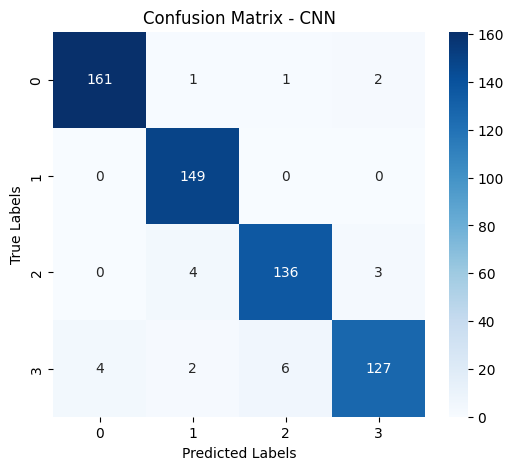

1/1 [==============================] - 0s 33ms/step
Predicted Category: Mortgage


In [ ]:
# Define Optimized CNN Model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(2),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(4, activation='softmax')
])


optimizer = Adam(learning_rate=0.0005)  # Lower learning rate for stable training
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_cat, 
                    epochs=30, batch_size=32, 
                    validation_data=(X_test_pad, y_test_cat), 
                    callbacks=[early_stop])


cnn_preds = model.predict(X_test_pad).argmax(axis=1)


print("Classification Report:\n", classification_report(y_test, cnn_preds))
conf_matrix = confusion_matrix(y_test, cnn_preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - CNN")
plt.show()


def predict_complaint(text):
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=max_len, padding='post')
    prediction = model.predict(text_pad)
    category_idx = prediction.argmax()
    category_mapping_reverse = {v: k for k, v in product_mapping.items()}
    return category_mapping_reverse.get(category_idx, "Unknown Category")


sample_text = """Applying for a mortgage or refinancing an existing mortgage"""
print("Predicted Category:", predict_complaint(sample_text))

Epoch 1/30
75/75 [==============================] - 3s 46ms/step - loss: 0.0824 - accuracy: 0.9777 - val_loss: 0.1256 - val_accuracy: 0.9631
Epoch 2/30
75/75 [==============================] - 3s 43ms/step - loss: 0.0617 - accuracy: 0.9836 - val_loss: 0.1634 - val_accuracy: 0.9614
Epoch 3/30
75/75 [==============================] - 3s 44ms/step - loss: 0.0354 - accuracy: 0.9916 - val_loss: 0.1546 - val_accuracy: 0.9631
Epoch 4/30
75/75 [==============================] - 3s 46ms/step - loss: 0.0286 - accuracy: 0.9916 - val_loss: 0.1649 - val_accuracy: 0.9597


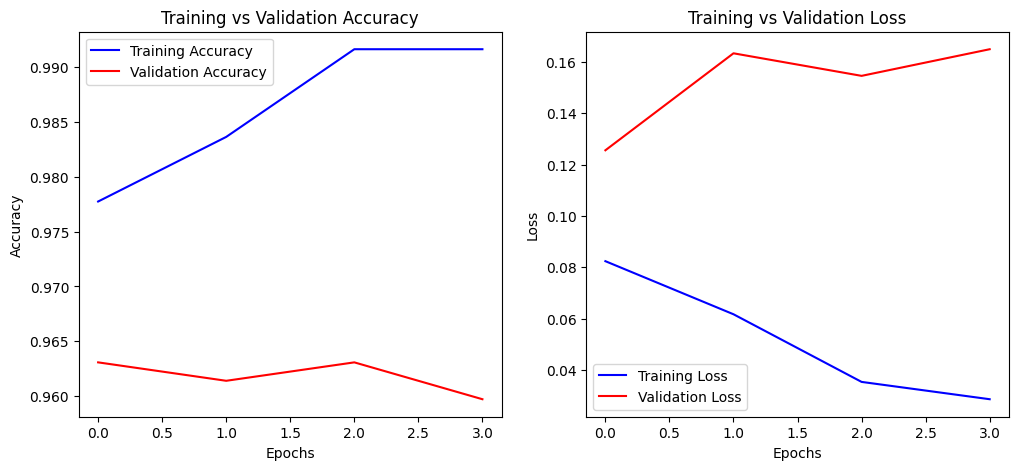

In [7]:
# Cell 12: Train Model with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train_pad, y_train_cat, 
                    epochs=30, batch_size=32, 
                    validation_data=(X_test_pad, y_test_cat), 
                    callbacks=[early_stop])

# Cell 18: Plot Training vs Validation Accuracy & Loss
plt.figure(figsize=(12, 5))

# Subplot 1: Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Training Accuracy", color='blue')
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Subplot 2: Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Training Loss", color='blue')
plt.plot(history.history['val_loss'], label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Show the plots
plt.show()


Custom Neural Network 

Epoch 1/30
75/75 [==============================] - 14s 165ms/step - loss: 1.3264 - accuracy: 0.5231 - val_loss: 1.1065 - val_accuracy: 0.5419
Epoch 2/30
75/75 [==============================] - 12s 159ms/step - loss: 0.5986 - accuracy: 0.8055 - val_loss: 0.9739 - val_accuracy: 0.7685
Epoch 3/30
75/75 [==============================] - 12s 160ms/step - loss: 0.2672 - accuracy: 0.9168 - val_loss: 1.0531 - val_accuracy: 0.6812
Epoch 4/30
75/75 [==============================] - 12s 160ms/step - loss: 0.1702 - accuracy: 0.9458 - val_loss: 0.9794 - val_accuracy: 0.6443
Epoch 5/30
75/75 [==============================] - 13s 169ms/step - loss: 0.1155 - accuracy: 0.9672 - val_loss: 0.3536 - val_accuracy: 0.9497
Epoch 6/30
75/75 [==============================] - 12s 158ms/step - loss: 0.0812 - accuracy: 0.9773 - val_loss: 0.1994 - val_accuracy: 0.9547
Epoch 7/30
75/75 [==============================] - 13s 170ms/step - loss: 0.0753 - accuracy: 0.9794 - val_loss: 0.1309 - val_accuracy: 0.9581

c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\loges\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a fut

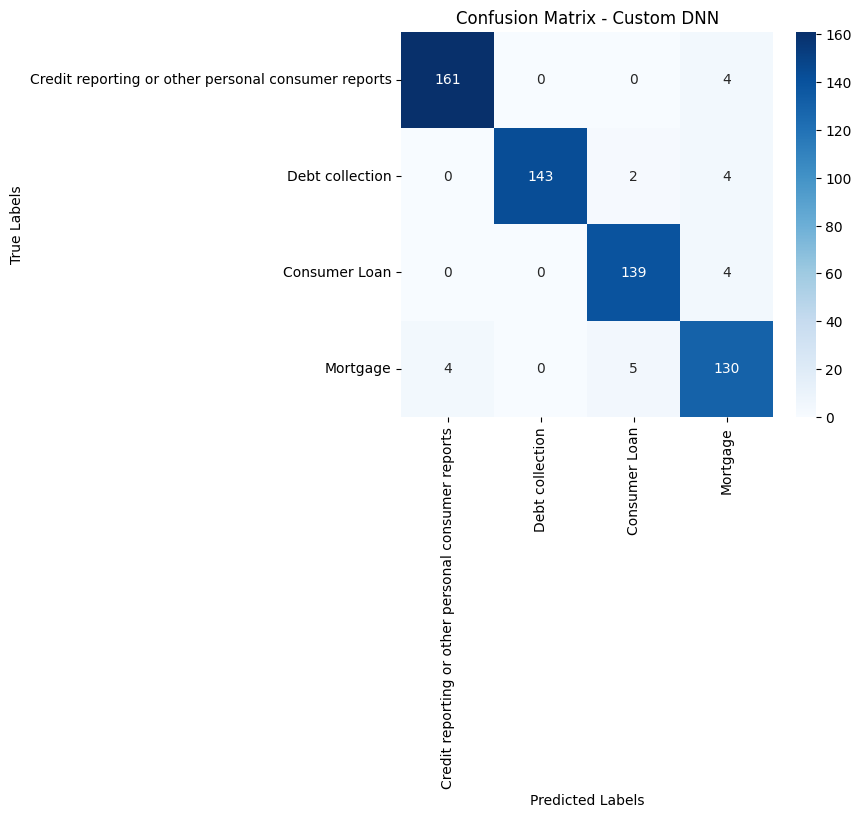

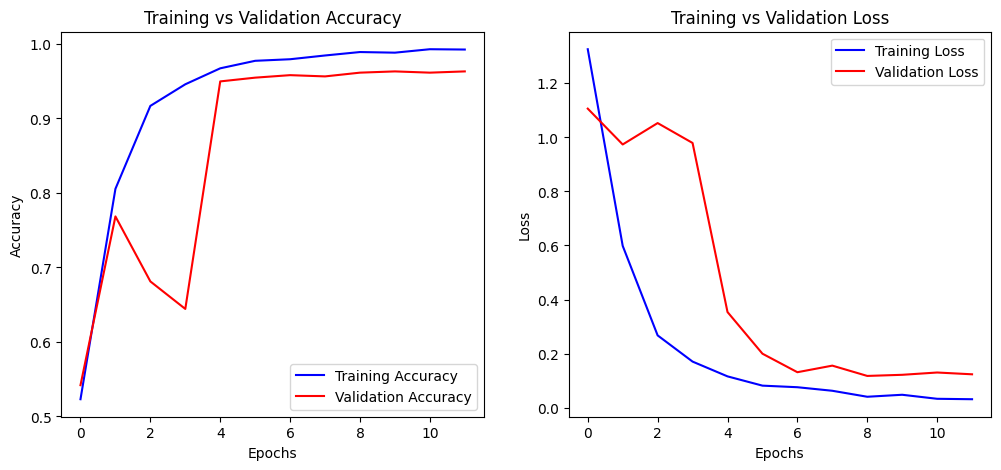

1/1 [==============================] - 0s 31ms/step
Predicted Category: Mortgage


In [18]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Flatten(),
    
    # Custom Dense Layer 1
    Dense(512, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),

    # Custom Dense Layer 2
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    # Custom Dense Layer 3
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    # Output Layer
    Dense(4, activation='softmax')
])

# Compile the Model
optimizer = Adam(learning_rate=0.0003)  # Lower learning rate for stable training
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the Model with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train_cat, 
    epochs=30, batch_size=32, 
    validation_data=(X_test_pad, y_test_cat), 
    callbacks=[early_stop]
)

# Get Predictions
dnn_preds = model.predict(X_test_pad).argmax(axis=1)

# Model Evaluation
print("Classification Report:\n", classification_report(y_test, dnn_preds))
conf_matrix = confusion_matrix(y_test, dnn_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=product_mapping.keys(), yticklabels=product_mapping.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Custom DNN")
plt.show()

# Training vs Validation Accuracy & Loss
plt.figure(figsize=(12, 5))

# Accuracy Graph
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Training Accuracy", color='blue')
plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Training Loss", color='blue')
plt.plot(history.history['val_loss'], label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()

# Function to Predict New Complaints using Custom DNN
def predict_complaint(text):
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=max_len, padding='post')
    prediction = model.predict(text_pad)
    category_idx = prediction.argmax()
    category_mapping_reverse = {v: k for k, v in product_mapping.items()}
    return category_mapping_reverse.get(category_idx, "Unknown Category")

# Example Prediction
sample_text = """Applying for a mortgage or refinancing an existing mortgage"""
print("Predicted Category:", predict_complaint(sample_text))

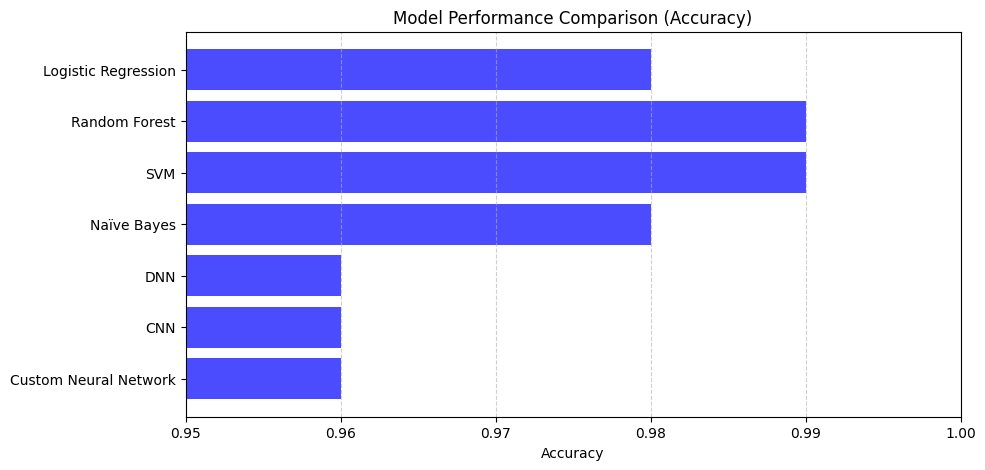

In [23]:
import matplotlib.pyplot as plt

# Model names
models = [
    "Logistic Regression", "Random Forest", "SVM", "Naïve Bayes", 
    "DNN", "CNN", "Custom Neural Network"
]

# Accuracy values
accuracy = [0.98, 0.99, 0.99, 0.98, 0.96, 0.96, 0.96]

# Plotting
plt.figure(figsize=(10, 5))
plt.barh(models, accuracy, color='blue', alpha=0.7)
plt.xlabel("Accuracy")
plt.title("Model Performance Comparison (Accuracy)")
plt.xlim(0.95, 1.00)  # Adjusting x-axis for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.gca().invert_yaxis()  # Invert y-axis to show the best model at the top

# Display the plot
plt.show()
